Метод штрафных функций относится к группе методов внешней точки, он начинает поиск с недопустимой точки и генерирует последовательность недопустимых решений, которая приближается к оптимальному решению извне допустимой области.

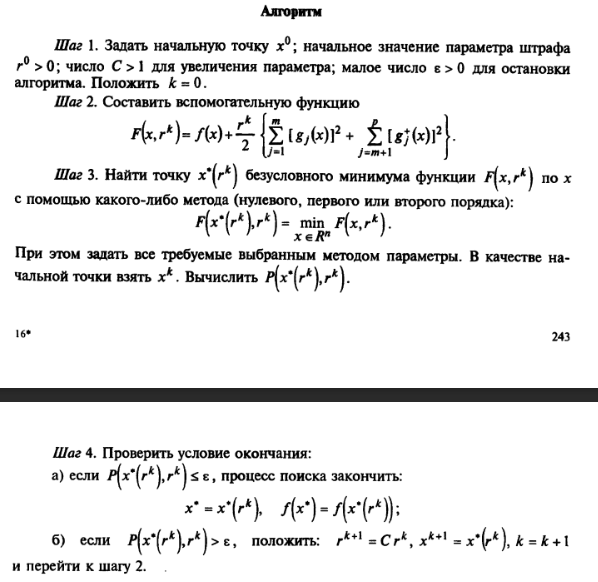

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from scipy.optimize import minimize_scalar
import numpy as np

def Gauss_Zeidel(func: callable, x: list, eps: float) -> float:
    results = []
    n = len(x)
    j = 0

    while True:
        for i in range(n):
            e = np.zeros(n)
            e[i] = 1

            _lambda = minimize_scalar(lambda _lambda: func(x + _lambda * e)).x
            x[i] += _lambda

        results.append(func(x))

        if j >= 1 and abs(results[j] - results[j-1]) < eps:
            return x
            
        j += 1

In [2]:
from prettytable import PrettyTable

def penalty_functions(f, h, g, x, r=0.01, c=5, eps=0.01):
    '''
    f - исследуемая функция
    h - список ограничений-равенств
    g - список ограничений-неравенств вида g_i <= 0
    x - начальная точка
    r (> 0) - начальное значение параметра штрафа (обычно маленькое)
    c ∈ [4, 10] - число для увеличения параметра
    eps - малое число для остановки алгоритма
    '''
    # для красоты
    table = PrettyTable(['r', 'x_n', 'y_n', 'f(x_n, y_n)', 'F'])
    td = [[r, x[0], x[1], f(x), np.inf]]

    # Составление штрафной функции
    penalty_h = lambda x: sum(f(x)**2 for f in h) # или модуль можно
    penalty_g = lambda x: sum(max(0, f(x))**2 for f in g) # срезка ^ 2

    penalty_f = lambda r: lambda x: r/2 * (penalty_h(x) + penalty_g(x))

    while penalty_f(r)(x) > eps:
        # Составление вспомогательной функции F
        F = lambda x: f(x) + penalty_f(r)(x)
        # Нахождение точки безусловного минимума функции F
        x = Gauss_Zeidel(F, x, eps)
        # Увеличение значения штрафа
        r *= c

        td.append([r, x[0], x[1], f(x), F(x)])

    for i in range(len(td)):
        table.add_row([round(float(x), 5) for x in td[i]])
    print(table)

    return x

**ПРИМЕР № 1**

In [3]:
import sympy as sym

variables = x1, x2, r = sym.symbols('x1 x2 r')

f = x1**2 + x2**2

g1 = x1 - 1 # = 0
g2 = x1 + x2 - 2 # <= 0

r = 0.1
C = 10

# вспомогательная функция
F = f + r/2 * (g1**2 + sym.Max(0, g2)**2)
F

x1**2 + x2**2 + 0.05*(x1 - 1)**2 + 0.05*Max(0, x1 + x2 - 2)**2

In [4]:
f = lambda x: x[0]**2 + x[1]**2

h1 = lambda x: x[0] - 1
h = np.array([h1])

g1 = lambda x: x[0] + x[1] - 2
g = np.array([g1])

x0 = [2, 2]
eps = 0.01
r = 0.1
c = 10

res1 = penalty_functions(f, h, g, x0, r, c, eps)
print(f"\n\nМинимальное значение в точке: ({float(res1[0]):3f}, {float(res1[1]):3f}, {float(f(res1)):3f})")

+----------+---------+------+-------------+---------+
|    r     |   x_n   | y_n  | f(x_n, y_n) |    F    |
+----------+---------+------+-------------+---------+
|   0.1    |   2.0   | 2.0  |     8.0     |   inf   |
|   1.0    | 0.04762 | 0.0  |   0.00227   | 0.45578 |
|   10.0   | 0.33333 | -0.0 |   0.11111   | 2.33333 |
|  100.0   | 0.83333 | -0.0 |   0.69444   | 2.08333 |
|  1000.0  | 0.98039 | -0.0 |   0.96117   |  1.1534 |
| 10000.0  |  0.998  | -0.0 |   0.99601   | 1.01593 |
| 100000.0 |  0.9998 | -0.0 |    0.9996   |  1.0016 |
+----------+---------+------+-------------+---------+


Минимальное значение в точке: (0.999800, -0.000000, 0.999600)


**ПРОВЕРКА**

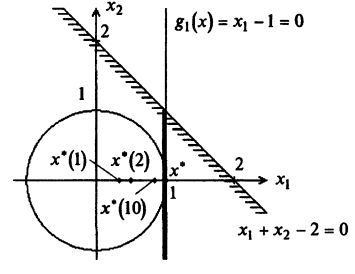

**ПРИМЕР № 2**

In [5]:
f = 4*x1 - x2**2 - 12

g1 = -x1
g2 = -x2
g3 = -10*x1 + x1**2 - 10*x2 + x2**2 + 34 # <= 0
g = [g1, g2, g3]
r = 0.001
C = 4

r *= C**3

F = f + r/2 * sum(sym.Max(0, f)**2 for f in g)
F

4*x1 - x2**2 + 0.032*Max(0, -x1)**2 + 0.032*Max(0, -x2)**2 + 0.032*Max(0, x1**2 - 10*x1 + x2**2 - 10*x2 + 34)**2 - 12

In [6]:
f = lambda x : 4*x[0] - x[1]**2 - 12

g1 = lambda x: -x[0] # <= 0
g2 = lambda x: -x[1] # <= 0
g3 = lambda x: - 10*x[0] + x[0]**2 - 10*x[1] + x[1]**2 + 34 # <= 0
g = [g1, g2, g3]

x0 = [0, 0]
eps = 0.05
r = 0.001
c = 4

res2 = penalty_functions(f, [], g, x0, r, c, eps)
print(f"\n\nМинимальное значение в точке: ({float(res2[0]):3f}, {float(res2[1]):3f}, {float(f(res2)):3f})")

+----------+---------+----------+-------------+------------+
|    r     |   x_n   |   y_n    | f(x_n, y_n) |     F      |
+----------+---------+----------+-------------+------------+
|  0.001   |   0.0   |   0.0    |    -12.0    |    inf     |
|  0.004   | 3.25604 | 39.05551 | -1524.30866 | 1106.07953 |
|  0.016   | 3.43072 | 23.22435 |  -537.64753 | 274.34691  |
|  0.064   | 3.65257 | 15.33963 |  -232.69397 |  42.43086  |
|  0.256   | 3.87168 | 11.50815 |  -128.95088 | -31.23938  |
|  1.024   | 4.03338 | 9.80009  |  -91.90818  | -59.34313  |
|  4.096   | 4.15135 | 9.17445  |  -79.56516  | -70.13126  |
|  16.384  | 4.23123 | 8.99484  |  -75.98213  | -73.50665  |
|  65.536  | 4.33299 | 8.96146  |  -74.97581  | -74.35113  |
| 262.144  | 4.38905 | 8.95743  |  -74.67942  | -74.52307  |
| 1048.576 | 4.40355 | 8.95637  |  -74.60241  | -74.56331  |
+----------+---------+----------+-------------+------------+


Минимальное значение в точке: (4.403551, 8.956373, -74.602406)


**ПРОВЕРКА**

In [7]:
from scipy.optimize import minimize, Bounds, NonlinearConstraint
import numpy as np

# ограничения неотрицательности
bounds = Bounds([0,0])

# единственное ограничение
constraints = NonlinearConstraint(
    lambda x: 10*x[0] - x[0]**2 + 10*x[1] - x[1]**2, 34, np.inf
)

res = minimize(
    fun=lambda x: 4*x[0] - x[1]**2 - 12,
    x0=[0,0],
    bounds=bounds,
    constraints=constraints
)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -74.76561966701715
       x: [ 4.123e+00  8.903e+00]
     nit: 10
     jac: [ 4.000e+00 -1.781e+01]
    nfev: 32
    njev: 10

In [8]:
res.x

array([4.12325112, 8.90273127])